In [4]:
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [5]:
HORIZON = 3                    # months to forecast
MAX_LAG = 3                    # number of lags to create
OHE_MAX_SERIES = 50            # switch to target-encoding if more series than this
REQUIRE_MONTH_IN_1_12 = True   # enforce valid month 1..12 if Month column present

In [6]:
CSV_PATH = None
if IN_COLAB and CSV_PATH is None:
    from google.colab import files  # type: ignore
    print("📁 Upload your dataset CSV (e.g., Demand_Forecast_Clean.csv)")
    uploaded = files.upload()
    CSV_PATH = list(uploaded.keys())[0]
    print("Loaded:", CSV_PATH)

assert CSV_PATH is not None, "Please upload your CSV first."
df = pd.read_csv(CSV_PATH)

📁 Upload your dataset CSV (e.g., Demand_Forecast_Clean.csv)


Saving Demand_Forecast_Clean.csv to Demand_Forecast_Clean.csv
Loaded: Demand_Forecast_Clean.csv


In [7]:

# Accepts common variations:
# - Product key: Product / Item / SKU
# - Optional Store key: Store / Location
# - Date OR Year + Month. If only Month, Year will be set to a constant (non-seasonal trend still works).
# - Target: Past_Order_Volume / Demand / Quantity / Sales / Units
col_aliases = {
    'product': 'Product', 'item': 'Product', 'sku': 'Product',
    'store': 'Store', 'location': 'Store',
    'past_order_volume': 'Past_Order_Volume', 'demand': 'Past_Order_Volume',
    'quantity': 'Past_Order_Volume', 'qty': 'Past_Order_Volume',
    'sales': 'Past_Order_Volume', 'units': 'Past_Order_Volume',
    'demand_level': 'Demand_Level',
    'date': 'Date', 'order_date': 'Date', 'ds': 'Date', 'timestamp': 'Date',
    'year': 'Year', 'month': 'Month'
}
def normalize_columns(df_in: pd.DataFrame) -> pd.DataFrame:
    df_out = df_in.copy()
    for c in list(df_out.columns):
        key = c.strip().lower().replace(" ", "_")
        if key in col_aliases and col_aliases[key] != c:
            df_out.rename(columns={c: col_aliases[key]}, inplace=True)
    return df_out

df = normalize_columns(df)

In [8]:
if 'Product' not in df.columns:
    df['Product'] = 'ALL'  # single series
else:
    df['Product'] = df['Product'].ffill()  # common source format has blank rows under a product header

# Allow optional Store dimension; if present, combine into a Series id
has_store = 'Store' in df.columns
if has_store:
    df['Store'] = df['Store'].astype(str).fillna('NA')
    df['Series'] = df['Store'].astype(str) + " | " + df['Product'].astype(str)
else:
    df['Series'] = df['Product'].astype(str)

In [9]:
# Target
target_candidates = [c for c in ['Past_Order_Volume','Demand','Quantity','Qty','Sales','Units'] if c in df.columns]
if not target_candidates:
    raise ValueError("Target column not found. Include one of: Past_Order_Volume / Demand / Quantity / Sales / Units")
TARGET = target_candidates[0]
df[TARGET] = pd.to_numeric(df[TARGET], errors='coerce')

# Drop rows without target
df = df[df[TARGET].notna()].copy()

# 2b) Time columns
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
else:
    df['Date'] = pd.NaT

if 'Year' not in df.columns or df['Year'].isna().all():
    if df['Date'].notna().any():
        df['Year'] = df['Date'].dt.year
    else:
        df['Year'] = 2024  # dummy year if only Month exists

if 'Month' in df.columns:
    df['Month'] = pd.to_numeric(df['Month'], errors='coerce').astype('Int64')
    if REQUIRE_MONTH_IN_1_12:
        df = df[(df['Month'].isna()) | ((df['Month'] >= 1) & (df['Month'] <= 12))]
else:
    df['Month'] = pd.NA

# Optional qualitative demand level
if 'Demand_Level' in df.columns:
    pass
else:
    df['Demand_Level'] = np.nan

# Sort in time order per series
sort_keys = ['Series']
if df['Date'].notna().any():
    sort_keys += ['Date']
else:
    sort_keys += ['Year']
    if 'Month' in df.columns:
        sort_keys += ['Month']
df = df.sort_values(sort_keys).reset_index(drop=True)

print("✅ Loaded rows:", len(df))
print("✅ Series count:", df['Series'].nunique())
print(df.groupby('Series')[TARGET].size().head())


✅ Loaded rows: 6
✅ Series count: 3
Series
Desk Lamp       2
File Cabinet    1
Headphones      3
Name: Past_Order_Volume, dtype: int64


In [10]:
def build_features(data: pd.DataFrame, max_lag: int = 3) -> pd.DataFrame:
    d = data.copy()
    d = d.sort_values(['Series','Year'] + (['Month'] if 'Month' in d.columns else []) + (['Date'] if 'Date' in d.columns else [])).copy()

    # Lags per series
    for lag in range(1, max_lag+1):
        d[f'lag_{lag}'] = d.groupby('Series')[TARGET].shift(lag)

    # Rolling means (shifted to avoid leakage)
    d['roll2'] = d.groupby('Series')[TARGET].rolling(window=2).mean().reset_index(level=0, drop=True).shift(1)
    d['roll3'] = d.groupby('Series')[TARGET].rolling(window=3).mean().reset_index(level=0, drop=True).shift(1)

    # Cyclical month
    if 'Month' in d.columns and d['Month'].notna().any():
        d['month_sin'] = np.sin(2 * np.pi * d['Month'].astype(float) / 12.0)
        d['month_cos'] = np.cos(2 * np.pi * d['Month'].astype(float) / 12.0)
    else:
        d['month_sin'] = np.nan
        d['month_cos'] = np.nan

    # Ordinal Demand_Level
    level_map = {'low':0, 'medium':1, 'high':2}
    d['Demand_Level_Ord'] = d['Demand_Level'].astype(str).str.lower().map(level_map)

    return d

feat_df = build_features(df, max_lag=MAX_LAG)

# Assemble feature lists
numeric_features = [c for c in ['lag_1','lag_2','lag_3','roll2','roll3','month_sin','month_cos','Demand_Level_Ord','Month','Year'] if c in feat_df.columns]
categorical_features = ['Series']  # global model learns per-series behavior
X_all = feat_df[numeric_features + categorical_features].copy()
y_all = feat_df[TARGET].copy()

n_series = feat_df['Series'].nunique()
use_onehot = n_series <= OHE_MAX_SERIES
print(f"🧠 Series: {n_series} | One-hot? {use_onehot}")

🧠 Series: 3 | One-hot? True


In [11]:
# 4) Per-series last-point holdout split
last_idx = feat_df.groupby('Series').tail(1).index
train_idx = feat_df.index.difference(last_idx)

X_train = X_all.loc[train_idx].copy()
y_train = y_all.loc[train_idx].copy()
X_val   = X_all.loc[last_idx].copy()
y_val   = y_all.loc[last_idx].copy()
val_series = feat_df.loc[last_idx, 'Series'].copy()

print("Train size:", X_train.shape, "Val size:", X_val.shape)

Train size: (3, 11) Val size: (3, 11)


In [12]:
# 5) Baselines
hist = feat_df.loc[train_idx, ['Series', TARGET]].copy()
global_mean = hist[TARGET].mean() if len(hist) else y_all.mean()

last_by_series = hist.groupby('Series')[TARGET].last()
mean_by_series = hist.groupby('Series')[TARGET].mean()

naive_pred = val_series.map(last_by_series).fillna(global_mean)
mean_pred  = val_series.map(mean_by_series).fillna(global_mean)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

def metrics(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mp = mape(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mp:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mp}

print("\n🔎 Validation metrics:")
m_naive = metrics(y_val, naive_pred, "Baseline-Naive")
m_mean  = metrics(y_val,  mean_pred, "Baseline-Mean")



🔎 Validation metrics:
Baseline-Naive -> MAE: 9.4444 | RMSE: 10.8926 | MAPE: 17.51%
Baseline-Mean -> MAE: 8.6944 | RMSE: 10.6577 | MAPE: 16.24%


In [13]:
# 6) Global ML model (RandomForest) with version-safe dense OHE
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# OneHotEncoder dense across sklearn versions
ohe_kwargs = {"handle_unknown": "ignore"}
try:
    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    ohe_kwargs["sparse_output"] = False   # sklearn >= 1.2
except TypeError:
    ohe_kwargs["sparse"] = False          # sklearn < 1.2

if use_onehot:
    ohe = OneHotEncoder(**ohe_kwargs)
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", ohe, categorical_features),
        ],
        remainder="drop"
    )
else:
    # Target-encoding (mean by series) using TRAIN ONLY
    series_means = hist.groupby('Series')[TARGET].mean().to_dict()
    def add_series_mean(df_in):
        df_out = df_in.copy()
        df_out['Series_Mean'] = df_out['Series'].map(series_means).fillna(global_mean)
        return df_out
    X_train = add_series_mean(X_train)
    X_val   = add_series_mean(X_val)
    numeric_features = numeric_features + ['Series_Mean']
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
        ],
        remainder="drop"
    )

# Safety: densify if any transformer still outputs sparse
to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("to_dense", to_dense),
    ("model", rf)
])

# Column sanity check
missing_num = [c for c in numeric_features if c not in X_train.columns]
missing_cat = [c for c in categorical_features if c not in X_train.columns] if use_onehot else []
if missing_num or missing_cat:
    raise ValueError(f"Missing columns -> numeric: {missing_num} | categorical: {missing_cat}")

pipe.fit(X_train, y_train)
ml_pred = pipe.predict(X_val)
m_ml = metrics(y_val, ml_pred, "ML-RandomForest")

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


ML-RandomForest -> MAE: 4.4654 | RMSE: 4.5345 | MAPE: 7.90%


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [14]:
# 7) Pick winner per series
val_tbl = pd.DataFrame({
    "Series": val_series.values,
    "y_true": y_val.values,
    "pred_naive": naive_pred.values,
    "pred_mean":  mean_pred.values,
    "pred_ml":    ml_pred
})
val_tbl["ae_naive"] = (val_tbl["y_true"] - val_tbl["pred_naive"]).abs()
val_tbl["ae_mean"]  = (val_tbl["y_true"] - val_tbl["pred_mean"]).abs()
val_tbl["ae_ml"]    = (val_tbl["y_true"] - val_tbl["pred_ml"]).abs()

def pick(row):
    # choose minimal absolute error method
    errs = {"naive": row["ae_naive"], "mean": row["ae_mean"], "ml": row["ae_ml"]}
    return min(errs, key=errs.get)

val_tbl["winner"] = val_tbl.apply(pick, axis=1)
method_map: Dict[str, str] = {r.Series: r.winner for r in val_tbl.itertuples()}
print("\n🏆 Chosen method per series:")
print(method_map)


🏆 Chosen method per series:
{'Desk Lamp': 'ml', 'File Cabinet': 'ml', 'Headphones': 'mean'}


In [15]:
# 8) Forecast next H months (recursive)
def next_month(y: int, m: int) -> Tuple[int, int]:
    m2 = m + 1
    y2 = y
    if m2 > 12:
        m2 = 1
        y2 = y + 1
    return y2, m2

def forecast_series(series_id: str, feat_df: pd.DataFrame, horizon: int = 3) -> List[Dict]:
    g = feat_df[feat_df["Series"] == series_id].copy()
    g = g.sort_values(["Year"] + (["Month"] if "Month" in g.columns else []))

    last_row = g.iloc[-1]
    year = int(last_row.get("Year", 2024))
    month = int(last_row["Month"]) if ("Month" in g.columns and not pd.isna(last_row["Month"])) else 12

    # Historical values for baselines & ML lags
    hist_vals = g[TARGET].tolist()

    method = method_map.get(series_id, "mean")

    out = []
    for step in range(1, horizon+1):
        year, month = next_month(year, month)

        if method == "ml":
            # Build future feature row
            lag_1 = hist_vals[-1] if len(hist_vals) >= 1 else np.nan
            lag_2 = hist_vals[-2] if len(hist_vals) >= 2 else np.nan
            lag_3 = hist_vals[-3] if len(hist_vals) >= 3 else np.nan
            roll2 = np.mean(hist_vals[-2:]) if len(hist_vals) >= 2 else np.nan
            roll3 = np.mean(hist_vals[-3:]) if len(hist_vals) >= 3 else np.nan
            month_sin = math.sin(2 * math.pi * (month/12.0))
            month_cos = math.cos(2 * math.pi * (month/12.0))
            # Use last known demand level if present
            demand_ord = g["Demand_Level_Ord"].dropna().iloc[-1] if "Demand_Level_Ord" in g.columns and g["Demand_Level_Ord"].notna().any() else np.nan

            row = {
                "lag_1": lag_1, "lag_2": lag_2, "lag_3": lag_3,
                "roll2": roll2, "roll3": roll3,
                "month_sin": month_sin, "month_cos": month_cos,
                "Demand_Level_Ord": demand_ord,
                "Month": month, "Year": year,
                "Series": series_id
            }
            Xf = pd.DataFrame([row])

            # If we used target-encoding: add Series_Mean at inference
            if not use_onehot:
                series_means = hist.groupby('Series')[TARGET].mean().to_dict()
                Xf['Series_Mean'] = series_means.get(series_id, global_mean)

            y_hat = float(pipe.predict(Xf)[0])

        elif method == "naive":
            y_hat = float(hist_vals[-1])
        else:  # "mean"
            y_hat = float(np.mean(hist_vals)) if len(hist_vals) else float(global_mean)

        out.append({
            "Series": series_id,
            "Forecast_Year": year,
            "Forecast_Month": month,
            "Forecast": y_hat,
            "Method": method
        })
        hist_vals.append(y_hat)

    return out

all_fc: List[Dict] = []
for s in feat_df['Series'].dropna().unique():
    all_fc += forecast_series(s, feat_df, horizon=HORIZON)

forecast_df = pd.DataFrame(all_fc).sort_values(["Series","Forecast_Year","Forecast_Month"]).reset_index(drop=True)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['lag_2' 'lag_3' 'roll2' 'roll3']. At least one non-missing value is needed for imputati

In [16]:
# 9) Split Series back into Store/Product columns for readability (if Store existed)
if has_store:
    split = forecast_df['Series'].str.split(" \| ", n=1, expand=True)
    forecast_df['Store'] = split[0]
    forecast_df['Product'] = split[1]
else:
    forecast_df['Product'] = forecast_df['Series']

print("\n📦 Forecasts (head):")
print(forecast_df.head())


📦 Forecasts (head):
         Series  Forecast_Year  Forecast_Month  Forecast Method       Product
0     Desk Lamp           2024               5  47.21250     ml     Desk Lamp
1     Desk Lamp           2024               6  47.21250     ml     Desk Lamp
2     Desk Lamp           2024               7  47.21250     ml     Desk Lamp
3  File Cabinet           2024               5  53.42875     ml  File Cabinet
4  File Cabinet           2024               6  53.42875     ml  File Cabinet


<>:3: SyntaxWarning: invalid escape sequence '\|'
<>:3: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-262702523.py:3: SyntaxWarning: invalid escape sequence '\|'
  split = forecast_df['Series'].str.split(" \| ", n=1, expand=True)



📈 Generating plots per series...


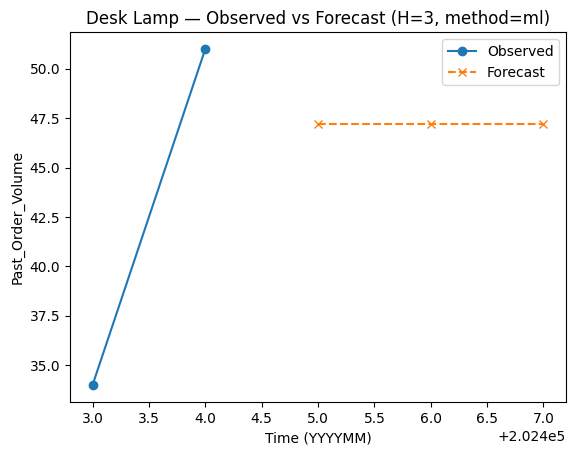

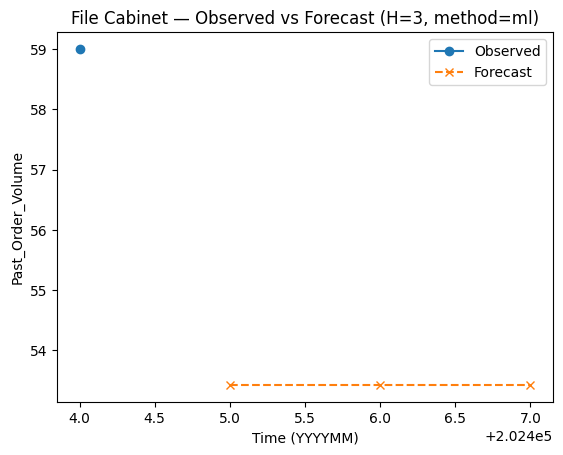

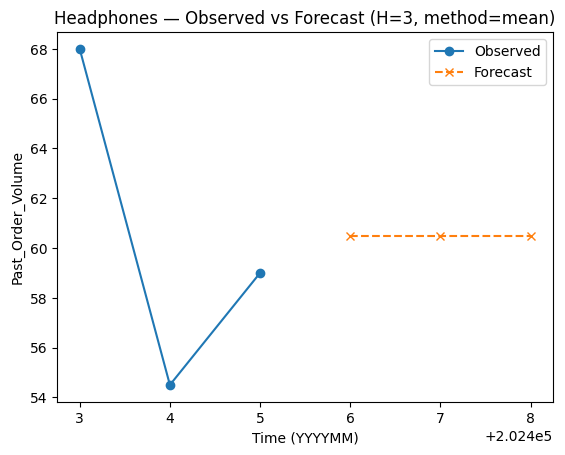

In [17]:
# 10) Plots (Observed vs Forecast)
def plot_series(series_id: str):
    g = feat_df[feat_df["Series"] == series_id].copy()
    g = g.sort_values(["Year"] + (["Month"] if "Month" in g.columns else []))
    if "Month" in g.columns and g["Month"].notna().any():
        g["t"] = g["Year"]*100 + g["Month"].fillna(0).astype(int)
    else:
        g["t"] = np.arange(len(g))

    f = forecast_df[forecast_df["Series"] == series_id].copy()
    f["t"] = f["Forecast_Year"]*100 + f["Forecast_Month"]

    plt.figure()
    plt.plot(g["t"], g[TARGET], marker="o", label="Observed")
    plt.plot(f["t"], f["Forecast"], marker="x", linestyle="--", label="Forecast")
    title_series = series_id
    used = method_map.get(series_id, "mean")
    plt.title(f"{title_series} — Observed vs Forecast (H={HORIZON}, method={used})")
    plt.xlabel("Time (YYYYMM)")
    plt.ylabel(TARGET)
    plt.legend()
    plt.show()

print("\n📈 Generating plots per series...")
for s in forecast_df['Series'].unique():
    plot_series(s)


In [18]:
 #11) Export CSV for Power BI
out_name = "forecast_next3_by_series.csv"
forecast_df.to_csv(out_name, index=False)
print(f"\n✅ Saved -> {out_name}")
if IN_COLAB:
    from google.colab import files  # type: ignore
    files.download(out_name)


✅ Saved -> forecast_next3_by_series.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# ---- Build a tidy FACT table for Power BI ----
fact_actuals = df.copy()

# Prefer a real Date. If you only have Year/Month, create a 1st-of-month Date
if 'Date' not in fact_actuals.columns or fact_actuals['Date'].isna().all():
    fact_actuals['Date'] = pd.to_datetime(dict(year=fact_actuals['Year'], month=fact_actuals['Month'].fillna(1).astype('Int64'), day=1))

# Only include 'Store' if it exists
actuals_cols = ['Series','Product','Date',TARGET]
if 'Store' in fact_actuals.columns:
    actuals_cols.insert(2, 'Store')

fact_actuals = fact_actuals[actuals_cols].copy()
fact_actuals['Type'] = 'Actual'
fact_actuals.rename(columns={TARGET:'Demand'}, inplace=True)

fact_fc = forecast_df.copy()
fact_fc['Date'] = pd.to_datetime(dict(year=fact_fc['Forecast_Year'], month=fact_fc['Forecast_Month'], day=1))
fact_fc = fact_fc[['Series','Date','Forecast','Method']].copy()
# Split Series back out if present
if ' | ' in fact_fc['Series'].iloc[0] if len(fact_fc)>0 else False:
    split = fact_fc['Series'].str.split(' \| ', n=1, expand=True)
    fact_fc['Store'] = split[0]
    fact_fc['Product'] = split[1]
else:
    # If no Store dimension was used
    fact_fc['Product'] = fact_fc['Series']
    fact_fc['Store'] = np.nan

fact_fc['Type'] = 'Forecast'
fact_fc.rename(columns={'Forecast':'Demand'}, inplace=True)

# Conditionally include 'Store' in the concatenated DataFrame
if has_store:
    fact = pd.concat([
        fact_actuals[['Series','Product','Store','Date','Demand','Type']],
        fact_fc[['Series','Product','Store','Date','Demand','Type']]
    ], ignore_index=True).sort_values(['Series','Date'])
else:
    fact = pd.concat([
        fact_actuals[['Series','Product','Date','Demand','Type']],
        fact_fc[['Series','Product','Date','Demand','Type']].drop(columns=['Store']) # Drop 'Store' if not present in actuals
    ], ignore_index=True).sort_values(['Series','Date'])


# Save to Drive for easy refresh in Power BI Service (optional)
try:
    import google.colab, os
    from google.colab import drive
    drive.mount('/content/drive')
    out_dir = '/content/drive/MyDrive/supplychain'
    os.makedirs(out_dir, exist_ok=True) # Create directory if it doesn't exist
    out_path = os.path.join(out_dir, 'forecast_fact.csv')
except:
    out_path = 'forecast_fact.csv'

fact.to_csv(out_path, index=False)
print("Saved FACT file:", out_path)
fact.head()

<>:23: SyntaxWarning: invalid escape sequence '\|'
<>:23: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-2028919707.py:23: SyntaxWarning: invalid escape sequence '\|'
  split = fact_fc['Series'].str.split(' \| ', n=1, expand=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved FACT file: /content/drive/MyDrive/supplychain/forecast_fact.csv


,Series,Product,Date,Demand,Type
0,Desk Lamp,Desk Lamp,2024-03-01,34.0000,Actual
1,Desk Lamp,Desk Lamp,2024-04-01,51.0000,Actual
6,Desk Lamp,Desk Lamp,2024-05-01,47.2125,Forecast
7,Desk Lamp,Desk Lamp,2024-06-01,47.2125,Forecast
8,Desk Lamp,Desk Lamp,2024-07-01,47.2125,Forecast


In [28]:
# --- Build FACT table (Actuals + Forecast) WITHOUT Drive ---
fact_actuals = df.copy()
if 'Date' not in fact_actuals.columns or fact_actuals['Date'].isna().all():
    fact_actuals['Date'] = pd.to_datetime(dict(
        year=fact_actuals['Year'],
        month=fact_actuals['Month'].fillna(1).astype('Int64'),
        day=1
    ))

# Only include 'Store' if it exists
actuals_cols = ['Series','Product','Date', TARGET]
if 'Store' in fact_actuals.columns:
    actuals_cols.insert(2, 'Store')

fact_actuals = fact_actuals[actuals_cols].copy()
fact_actuals['Type'] = 'Actual'
fact_actuals.rename(columns={TARGET: 'Demand'}, inplace=True)

fact_fc = forecast_df.copy()
fact_fc['Date'] = pd.to_datetime(dict(
    year=fact_fc['Forecast_Year'],
    month=fact_fc['Forecast_Month'],
    day=1
))
fact_fc = fact_fc[['Series','Date','Forecast','Method']].copy()

# Split "Store | Product" back if present and handle Store column consistently
if len(fact_fc) and (' | ' in str(fact_fc['Series'].iloc[0])):
    split = fact_fc['Series'].str.split(' \| ', n=1, expand=True)
    fact_fc['Store'] = split[0]
    fact_fc['Product'] = split[1]
else:
    # If no Store dimension was used, ensure fact_fc also doesn't have a Store column for concatenation
    fact_fc['Product'] = fact_fc['Series']
    if 'Store' in fact_fc.columns:
        fact_fc = fact_fc.drop(columns=['Store'])


fact_fc['Type'] = 'Forecast'
fact_fc.rename(columns={'Forecast': 'Demand'}, inplace=True)

# Define columns to include in the concatenated DataFrame
concat_cols = ['Series','Product','Date','Demand','Type']
if has_store:
    concat_cols.insert(2, 'Store')

fact = pd.concat(
    [fact_actuals[concat_cols],
     fact_fc[concat_cols]],
    ignore_index=True
).sort_values(['Series','Date'])


# Save locally in the Colab runtime (not Drive)
fact.to_csv('forecast_fact.csv', index=False)
forecast_df.to_csv('forecast_next3_by_series.csv', index=False)

print("Saved locally:")
print(" - forecast_fact.csv")
print(" - forecast_next3_by_series.csv")

Saved locally:
 - forecast_fact.csv
 - forecast_next3_by_series.csv


<>:29: SyntaxWarning: invalid escape sequence '\|'
<>:29: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipython-input-2983661212.py:29: SyntaxWarning: invalid escape sequence '\|'
  split = fact_fc['Series'].str.split(' \| ', n=1, expand=True)
